In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [4]:
plt.style.use("../style1.mplstyle")

In [5]:
@njit
def chemostat_dynamics(t,y,args):
    mu,k,yiel,delta,s = args
    n,c = y
    dn = mu * n * c / (k + c) - delta * n
    dc = delta*(s-c) - mu * n/yiel * c / (k + c)

    return np.array([dn,dc])

In [118]:
mu = 0.4
delta = 0.2
k = 0.8
s = 10
yiel = 1

In [212]:
initialn = 0.05
initialc = s
teval = np.linspace(0,72,100000)

In [213]:
soln_n = integrate.solve_ivp(chemostat_dynamics, (0,teval[-1]), [initialn,initialc], args=((mu,k,yiel,delta,s),), t_eval=teval,rtol=1e-6,atol=1e-6)

Text(0, 0.5, 'OD')

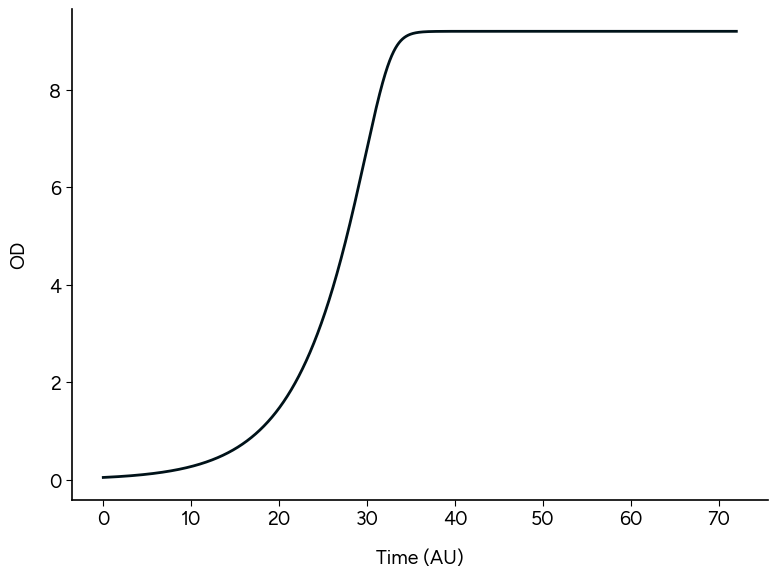

In [214]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.xlabel("Time (AU)")
plt.ylabel("OD")


(0.0, 10.460000105637377)

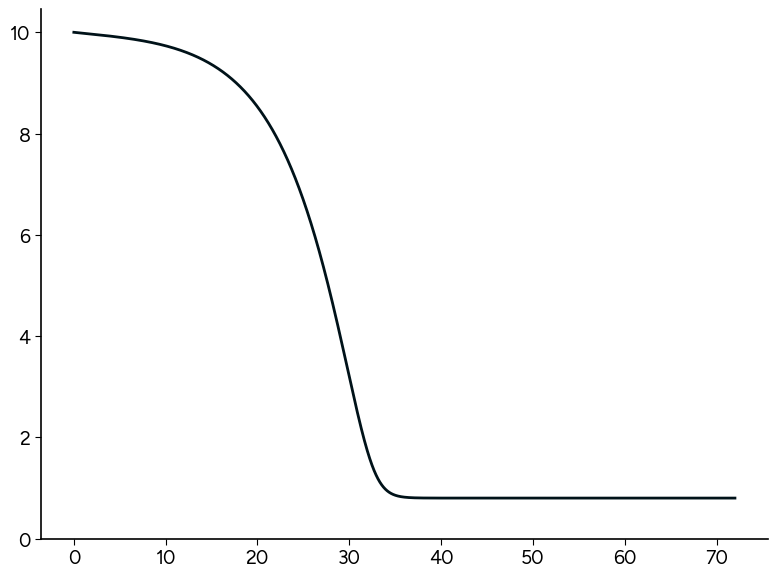

In [215]:
plt.plot(teval,soln_n.y[1],label="Resource")

plt.ylim(0,)


In [216]:
@njit
def glv_rhs(t,y,g,alpha):
    dydot = y*(g - alpha*y)
    return dydot

In [217]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

theory_soln = lambda t,g,alpha: logistic_solution(t,g,alpha,initialn)

In [218]:
def glv_error(params,chemostatSoln):
    gvec,alphamatrix = params
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(gvec,alphamatrix),t_eval=teval,rtol=1e-6,atol=1e-6)
    try:
        error = np.sum((integrated_soln.y[0] - chemostatSoln)**2)
    except:
        print(params)
        integrated_soln
    return np.sum((integrated_soln.y[0] - chemostatSoln)**2)

In [219]:
glv_lsq = optimize.minimize(glv_error,[0.1,0.1],args=(soln_n.y[0]),method="Nelder-Mead",bounds=[(0,None),(0,None)])

g,alpha = glv_lsq.x

print(g,alpha)

0.1999947993016971 0.021186823803255303


In [220]:
soln_glv_bootstrap = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(g,alpha),t_eval=teval,rtol=1e-6,atol=1e-6)

In [221]:
fitvals,fitcorr  = optimize.curve_fit(theory_soln,teval,soln_n.y[0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g,alpha = fitvals
print(g,alpha)

soln_glv_theoryfit = integrate.solve_ivp(glv_rhs, (0,teval[-1]), [initialn], args=(g,np.array([[alpha]])), t_eval=teval)

0.19999414844551167 0.02118674977720203


Text(0, 0.5, 'OD')

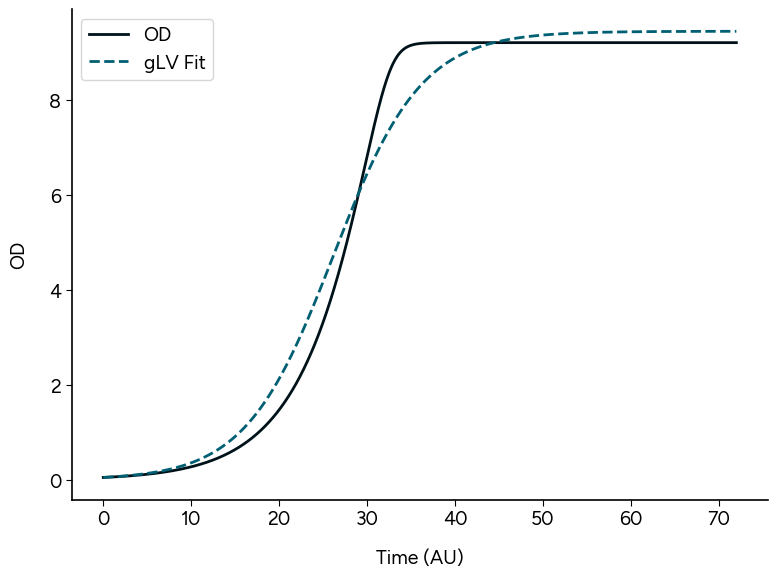

In [222]:
plt.plot(teval,soln_n.y[0],label="OD")
# plt.plot(teval,soln_glv_theoryfit.y[0],label="GLV")
plt.plot(teval,soln_glv_bootstrap.y[0],label="gLV Fit",ls="--")

plt.legend()
plt.xlabel("Time (AU)")
plt.ylabel("OD")

In [223]:
def glv_approx_params(c,mu,k,yiel,delta,s):
    sij = -mu*k / (k+c)**2
    sigma = delta*(s-c) 
    dsigma_dr = -delta
    f = mu*c / (k+c) / yiel
    df_dr = -mu*k / (k+c)**2 / yiel

    mij = df_dr / f * sigma - dsigma_dr
    gcalc = sij / mij * sigma
    alphacalc = -sij /mij * f
    return gcalc,alphacalc

In [224]:
def third_order_approx(c,mu,k,yiel,delta,s):
    sij = -mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = -mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    minv = 1/delta * (1+ mu*k*f/eC / delta / yiel / (k+c)**2)
    gcalc = fi *minv / sij
    alphacalc = eC / sij * minv
    return gcalc,alphacalc

In [225]:
def qssC(n,mu,k,yiel,delta,s):
    bterm = (-s + k + n*mu/delta/yiel)
    aterm = 1
    cterm = -s * k
    return (-bterm + np.sqrt(bterm**2 - 4*aterm*cterm))/(2*aterm)

In [226]:
qssCvsT = np.array([qssC(n,mu,k,yiel,delta,s) for n in soln_n.y[0]])

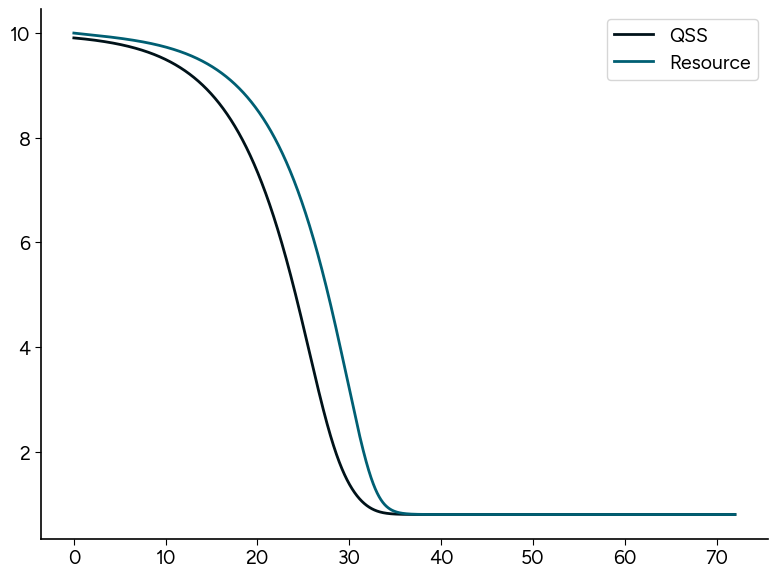

In [227]:
plt.plot(teval,qssCvsT,label="QSS")
plt.plot(teval,soln_n.y[1],label="Resource")

plt.legend()

In [228]:
paramsOfApprox = glv_approx_params(qssCvsT[-1],mu,k,yiel,delta,s)
paramsApproxTimeTraj = np.array([glv_approx_params(c,mu,k,yiel,delta,s) for c in qssCvsT])

In [229]:
@njit
def timeDepGLV(t,y,gTime,alphaTime):
    indexT = np.where(teval >= t)[0][0]
    g,alpha = gTime[indexT],alphaTime[indexT]
    return y*g*(1 - alpha*y/g)

In [230]:
gTime = paramsApproxTimeTraj[:,0]
alphaTime = paramsApproxTimeTraj[:,1]

In [231]:
gTime[0],alphaTime[0]

(-0.00025843729168051837, 0.0051687458336103585)

In [232]:
gTime[-1],alphaTime[-1]

(0.24210528797443803, -0.026315794069340443)

In [233]:
@njit
def rk4Integrator(func,t,y,dt,args):
    k1 = dt*func(t,y,*args)
    k2 = dt*func(t+dt/2,y+k1/2,*args)
    k3 = dt*func(t+dt/2,y+k2/2,*args)
    k4 = dt*func(t+dt,y+k3,*args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

In [234]:
-k + np.sqrt(k**2 + k*s)

2.139387691339814

In [235]:
qssCvsT[392]

9.90291692790975

In [237]:
tineDependentGLV = integrate.solve_ivp(timeDepGLV,[0,teval[-1]],[initialn],args=(gTime,alphaTime),rtol=1e-8,atol=1e-12)
tineDependentGLV

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  4.463e-02 ...  4.885e+01  4.885e+01]
        y: [[ 5.000e-02  5.000e-02 ...  3.245e+13  3.455e+13]]
      sol: None
 t_events: None
 y_events: None
     nfev: 78800
     njev: 0
      nlu: 0

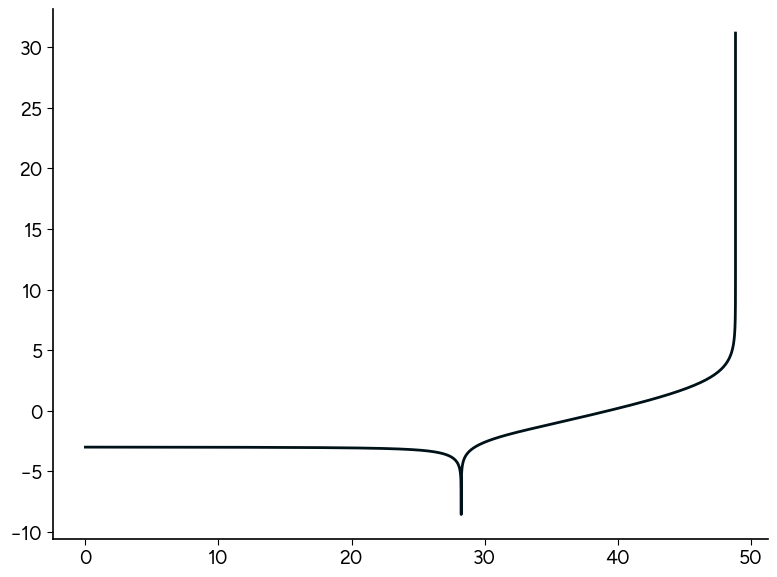

In [239]:
plt.plot(tineDependentGLV.t,np.log(tineDependentGLV.y[0]),label="Time Dependent GLV")

In [ ]:
# timeDepN = np.zeros_like(soln_n.y[0])
# timeDepN[0] = initialn
# dt = teval[1] - teval[0]

# for i in range(1,len(teval)):
#     timeDepN[i] = rk4Integrator(timeDepGLV,teval[i-1],timeDepN[i-1],dt,(gTime[i-1],alphaTime[i-1]))
    

ValueError: x and y must have same first dimension, but have shapes (100000,) and (6864,)

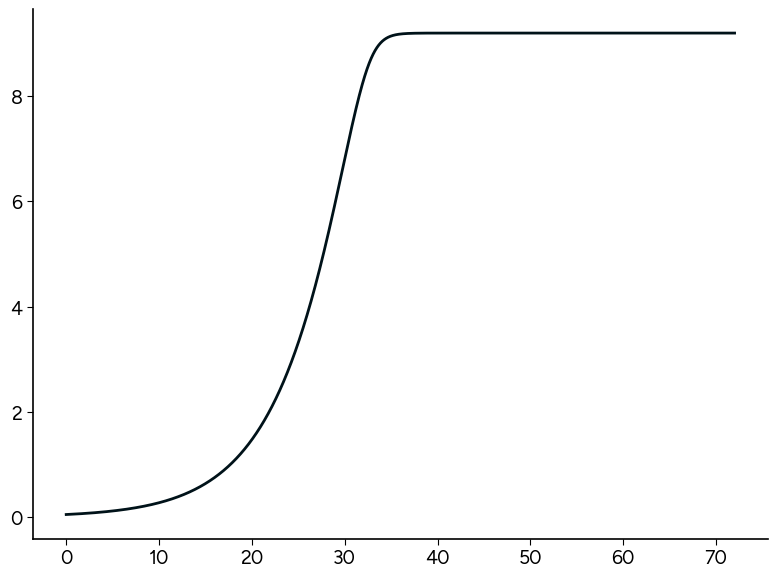

In [240]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,tineDependentGLV.y[0],label="Time Dep GLV")

plt.legend()
plt.xlabel("Time (AU)")
plt.ylabel("OD")

Text(0, 0.5, '$r(t)$')

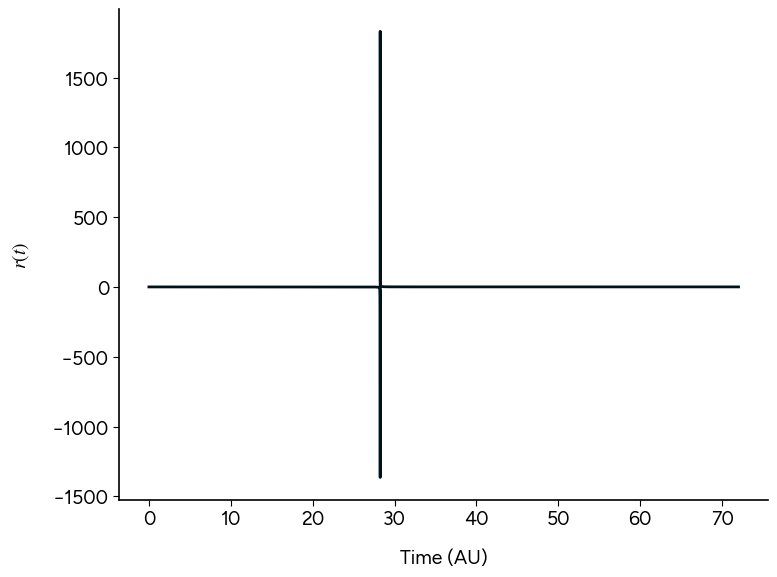

In [242]:
plt.plot(teval,gTime)

plt.xlabel("Time (AU)")
plt.ylabel(r"$r(t)$")


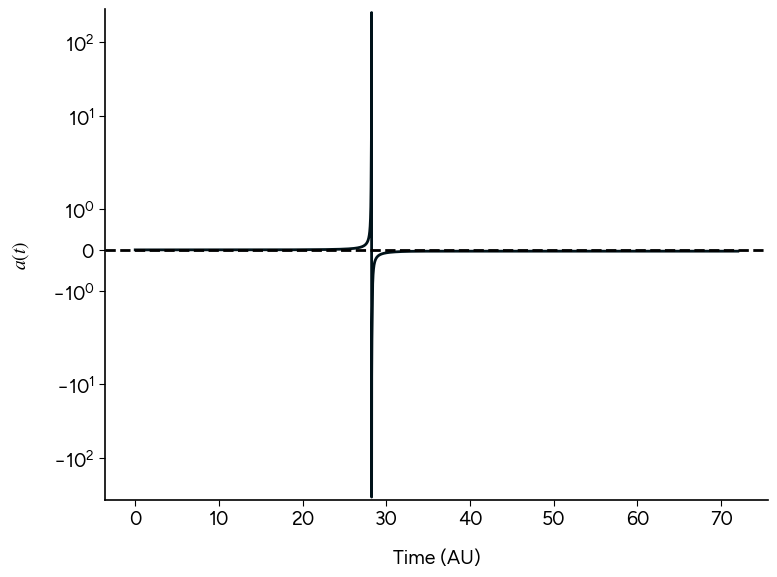

In [243]:
plt.plot(teval,alphaTime)
plt.axhline(0,ls="--",color="black")
plt.xlabel("Time (AU)")
plt.ylabel(r"$a(t)$")
plt.yscale("symlog")

In [74]:
fullFitArray = np.load("data/fullFitArray_2.npy")
qssFitArray = np.load("data/qssFitArray_2.npy")
fitErrors = np.load("data/fullFitErrors_2.npy")
muFittingArray = np.load("data/muArray_2.npy")
kMFittingArray = np.load("data/kArray_2.npy")

In [75]:
muFittingArray[4],kMFittingArray[6]

(0.181, 0.613)

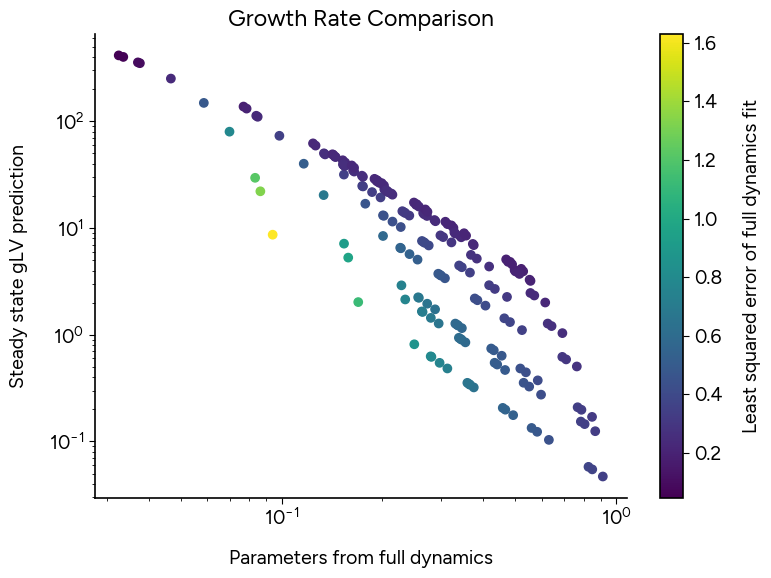

In [83]:
plt.scatter(fullFitArray[:,:,0].flatten(),qssFitArray[:,:,0].flatten(),c=fitErrors[:,:].flatten(),cmap="viridis")
cbar = plt.colorbar()
plt.xlabel("Parameters from full dynamics")
plt.ylabel("Steady state gLV prediction")
cbar.set_label("Least squared error of full dynamics fit")
plt.xscale("log")
plt.yscale("log")
plt.title("Growth Rate Comparison")
# plt.ylim(1e-3,5e3)
plt.show()

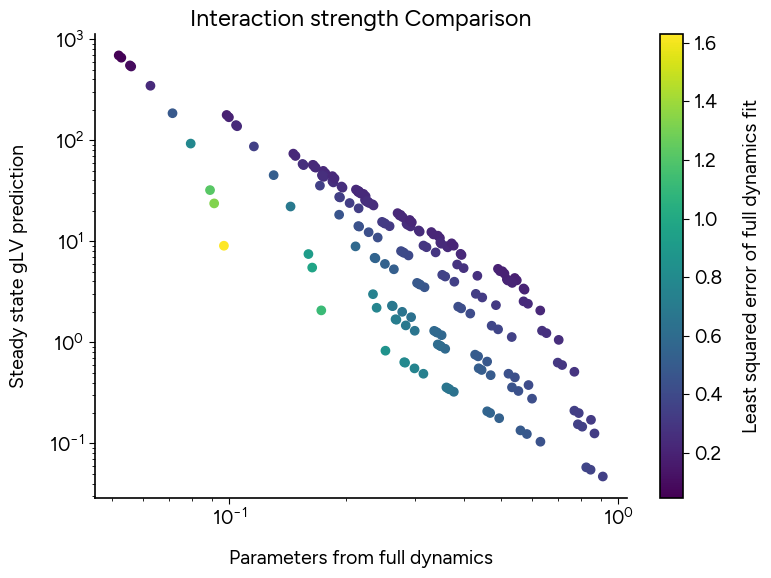

In [85]:
plt.scatter(fullFitArray[:,:,1].flatten(),qssFitArray[:,:,1].flatten(),c=fitErrors[:,:].flatten(),cmap="viridis")
cbar = plt.colorbar()
plt.xlabel("Parameters from full dynamics")
plt.ylabel("Steady state gLV prediction")
cbar.set_label("Least squared error of full dynamics fit")
plt.title("Interaction strength Comparison")
plt.xscale("log")
plt.yscale("log")

# plt.ylim(1e-3,1e5)
plt.show()

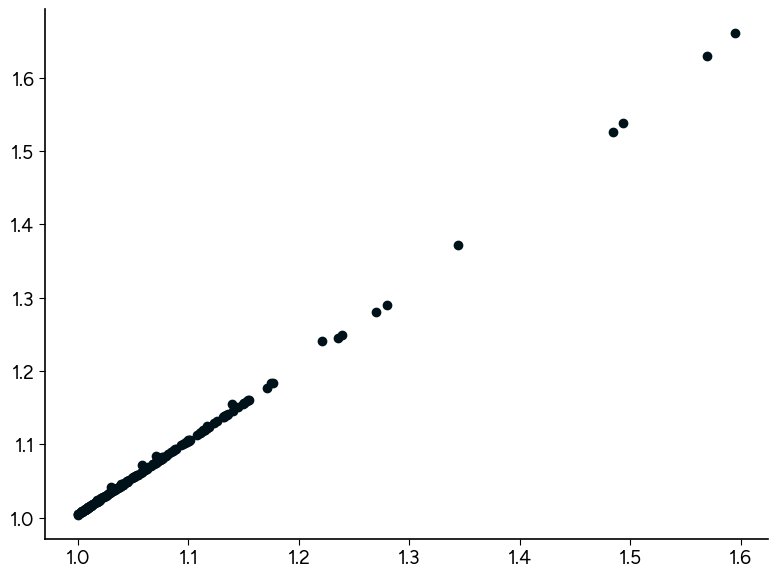

In [78]:
plt.scatter((fullFitArray[:,:,1]/fullFitArray[:,:,0]).flatten(),(qssFitArray[:,:,1]/qssFitArray[:,:,0]).flatten())

# plt.xscale("log")
# plt.yscale("log")

# plt.ylim(0.1,)
# plt.xlim(0.7,)

plt.show()